In [968]:
%load_ext autoreload
%autoreload 2 
#default_exp model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [983]:
#exporti
from fastai.tabular.all import * 
from tabnet.sparsemax import Sparsemax

In [3]:
! pip install -e ../../libraries/fastai ../../libraries/fastcore 

Processing /workspace/libraries/fastcore
Obtaining file:///workspace/libraries/fastai
  Created wheel for fastcore: filename=fastcore-1.1.1-py3-none-any.whl size=42589 sha256=dce21d93e8bbb9cac4e57b9712456d2f454ecca678f137a732743820e382eb25
  Stored in directory: /tmp/pip-ephem-wheel-cache-tn7yq08n/wheels/7f/b2/14/bd5b5a33cd6949520fb130db87d6a4f0566b7514b95107fa83
Successfully built fastcore
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.1.1
    Uninstalling fastcore-1.1.1:
      Successfully uninstalled fastcore-1.1.1
  Attempting uninstall: fastai
    Found existing installation: fastai 2.0.16
    Uninstalling fastai-2.0.16:
      Successfully uninstalled fastai-2.0.16
  Running setup.py develop for fastai
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


# Creating the model 


In [1015]:
class TabNet(Module):
    
    def __init__(self, in_features, out_features, n_d, n_a, n_steps, n_shared_ft_blocks=1,
                         n_independent_ft_blocks=2, gamma=1):        
        store_attr()
        
        
        intermediate_features = n_d + n_a 
        self.shared_ft_blocks = [FeatureTransformerBlock(in_features, intermediate_features, is_first=True)] + \
                                [FeatureTransformerBlock(intermediate_features, intermediate_features, is_first=False) 
                                                                             for _ in range(n_shared_ft_blocks-1)]
        
        
        self.initial_bn = BatchNorm(in_features, ndim=1)
        self.initial_ft = FeatureTransformer(self.shared_ft_blocks, n_d, n_a, n_independent_ft_blocks)
        
        self.att_steps = nn.ModuleList([AttentiveTransformer(n_a, in_features) for i in range(self.n_steps)])
        self.ft_steps = nn.ModuleList([FeatureTransformer(self.shared_ft_blocks, n_d, n_a, n_independent_ft_blocks) 
                                            for i in range(self.n_steps)])
        
        self.final_fc = nn.Linear(n_d, out_features)
    
    def forward(self, x_cat, x_cont):
        output = 0
        x = self.initial_bn(x_cont)
        _, a = self.initial_ft(x)
        
        prior = torch.ones(self.in_features)
        
        for i in range(self.n_steps):
            M = self.att_steps[i](a, prior)
            prior = (self.gamma - M)*prior
            res = M * x
            d, a = self.ft_steps[i](res)
            output = output + nn.functional.relu(d)
        
        res = self.final_fc(output)
        return res

In [1016]:
class AttentiveTransformer(Module):
    
    def __init__(self, n_a, in_features):
        store_attr()
        self.fc = nn.Linear(n_a, in_features)
        self.bn = BatchNorm(in_features, ndim=1)
        self.sparsemax = Sparsemax()
        
    def forward(self, a, prior):
        a = self.fc(a)
        a = self.bn(a)
        a = prior * a
        M = self.sparsemax(a)
        return M

In [1017]:
class FeatureTransformer(Module):
    
    def __init__(self, shared_blocks, n_d, n_a, n_independent_ft_blocks):
        store_attr()
        intermediate_features = n_d + n_a
        steps = [FeatureTransformerBlock(intermediate_features, intermediate_features, False) 
                             for _ in range(n_independent_ft_blocks)]
        self.steps = nn.Sequential(*[*shared_blocks, *steps])
        
    def forward(self, x):
        res = self.steps(x)
        d, a = res[:,:self.n_d], res[:,self.n_d:]
        return d, a

In [1018]:
class FeatureTransformerBlock(Module):
    def __init__(self, in_features, intermediate_features, is_first, norm=torch.sqrt(tensor(0.5))):
        store_attr()
        
        self.block1 = self._create_inner_block(is_first=True)
        self.block2 = self._create_inner_block(is_first=False)
        
        
    def forward(self, x):
        x1 = self.block1(x)
        if not self.is_first: x1 = (x1 + x)*self.norm
        x2 = self.block2(x1)
        x2 = (x2 + x1)*self.norm
        return x2
        
        
    def _create_inner_block(self, is_first):
        intermediate_features = self.intermediate_features
        in_features = self.in_features if is_first else intermediate_features
        
        return nn.Sequential(*[
            nn.Linear(in_features, 2*intermediate_features),
            BatchNorm(2*intermediate_features, ndim=1),
            nn.GLU(),
        ])        
        
        
    

In [1019]:
N = 3
in_features = 32
n_d = n_a = 7 
n_steps = 3
out_features = 10

a = torch.randn((N, in_features))
ft = FeatureTransformerBlock(in_features, n_d+n_a, is_first=True)
test_eq(ft(a).shape, (N, n_d+n_a))

In [1020]:
a = torch.randn((N, in_features))
tabnet = TabNet(in_features, out_features, n_d, n_a, n_steps)
test_eq(tabnet(a, a).shape, (N, out_features))

# Testing it out 

In [1021]:
data_dir = Path('./data')

In [1022]:
def extract_gzip(file, dest=None):
    dest = dest or Path(dest)
    with gzip.open(file, 'rb') as f_in:
        with open(dest / file.stem, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [1023]:
forest_type_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz'
forest_path = untar_data(forest_type_url, dest=data_dir, extract_func=extract_gzip)

In [1024]:
df = pd.read_csv(forest_path, nrows=10_000, header=None); df.head()
df = df_shrink(df)

In [1025]:
dls = TabularDataLoaders.from_df(df, path=data_dir, y_names=54, y_block=CategoryBlock,
    cat_names =  [],
    cont_names = df.columns.difference([54]).to_list(),
    procs = [Categorify, FillMissing, Normalize], bs=3)

In [1028]:
tabnet = TabNet(54, 30, 64, 64, 5, n_shared_ft_blocks=2, n_independent_ft_blocks=2, gamma=1.5)
learn = TabularLearner(dls, tabnet, metrics=[accuracy])

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.009120108559727669)

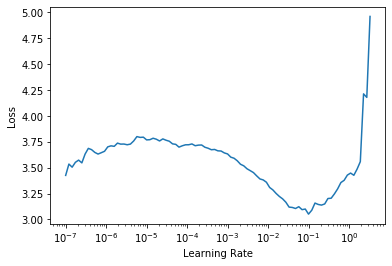

In [1029]:
learn.lr_find()

In [ ]:
conv = nn.Conv2d

In [967]:
learn.fine_tune(4, 1e-2)


KeyboardInterrupt



# Export

In [ ]:
from nbdev.export import notebook2script
notebook2script()